<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction à la Recherche Opérationelle</h1><br/>M2 Statistique Science des Données (SSD)</center></td>
<td width=15%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Anatoli Juditsky</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> </td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 30pt; font-weight: bold">TP 3 - Moindres Carrés Positifs </a></center>
<br/><br/>

Élève: Garance Malnoë

# 1- Problème de régression positive

On considère le modèle de régression normale
$$ y=X\theta+\sigma\xi,\;\;\xi\sim \mathcal{N}(0, I_m),$$
où  $X\in \mathbb{R}^{m\times n}$ et $y\in \mathbb{R}^m$ sont les observables, et $\theta\in \mathbb{R}_+^n$ est le paramètre inconnu.

Dans les moindres carrés positifs, on modélise $\theta$ comme un vecteur à valeurs positives et donc on ne cherche que les solutions positives du problème des moindres carrés. On veut donc résoudre le problème d'optimisation:
$$\tag{P1} \min_{\theta\in  \mathbb{R}^n} \|X\theta-y\|_2^2,~~\;\text{sous contrainte}\;\theta\geq0.$$



In [1]:
# Import des bibliothèques
import warnings

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

# Import des fonctions personnelles dans des fichiers annexes
from pretty_print import pretty_result
from calculs import (
    norm_inf_difference_thetas,
    grille_solutions_P2,
    grille_solutions_P2_dual
)
from plot import pretty_plot

# Ne pas afficher les warnings
warnings.filterwarnings("ignore")

## Exemple de données pour tester votre code

In [2]:
# Exemple jouet
n = 10
m = 20
sigma = 0.1

# Reproductibilité
np.random.seed(1)

# Simulation de X, theta et xi
X = np.random.randn(m,n)
theta_true = np.random.rand(n)
xi = np.random.randn(m)

# Calcul de y
y = np.dot(X,theta_true) + sigma*xi

Affichons les valeurs obtenues avec la graine sélectionnée :

In [3]:
print(f"La matrice X :\n{X}")

La matrice X :
[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944 -1.09989127
  -0.17242821 -0.87785842  0.04221375  0.58281521]
 [-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595 -0.68372786
  -0.12289023 -0.93576943 -0.26788808  0.53035547]
 [-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613 -0.0126646
  -1.11731035  0.2344157   1.65980218  0.74204416]
 [-0.19183555 -0.88762896 -0.74715829  1.6924546   0.05080775 -0.63699565
   0.19091548  2.10025514  0.12015895  0.61720311]
 [ 0.30017032 -0.35224985 -1.1425182  -0.34934272 -0.20889423  0.58662319
   0.83898341  0.93110208  0.28558733  0.88514116]
 [-0.75439794  1.25286816  0.51292982 -0.29809284  0.48851815 -0.07557171
   1.13162939  1.51981682  2.18557541 -1.39649634]
 [-1.44411381 -0.50446586  0.16003707  0.87616892  0.31563495 -2.02220122
  -0.30620401  0.82797464  0.23009474 

In [4]:
print(f"Le paramètre theta_true choisi :\n{theta_true}")

Le paramètre theta_true choisi :
[0.86447943 0.322681   0.67078879 0.45087394 0.38210275 0.41081135
 0.40147958 0.31738395 0.62191937 0.43024727]


In [5]:
print(f"Le vecteur xi :\n{xi}")

Le vecteur xi :
[-0.3264995  -1.34267579  1.11438298 -0.58652394 -1.23685338  0.87583893
  0.62336218 -0.43495668  1.40754     0.12910158  1.6169496   0.50274088
  1.55880554  0.1094027  -1.2197444   2.44936865 -0.54577417 -0.19883786
 -0.7003985  -0.20339445]


In [6]:
print(f"Le vecteur y :\n{y}")

Le vecteur y :
[ 2.71309295e-01 -1.39753098e-02  1.39274264e-01 -9.10972322e-01
  5.27197841e-01  6.61478526e-01  1.87483965e+00 -1.05162452e+00
  7.30756787e-01  5.53485723e-01  2.02883942e-01 -9.15152168e-01
  1.81004810e+00 -5.05907793e-01  1.52973420e+00  4.37073185e-01
  3.37579095e-01  1.94806670e+00  1.26397945e-03  3.79272711e+00]


Il est important de noter que le vecteur **$\theta_{true}$ est simulé selon une loi uniforme sur $[0;1]$** : $\: \theta_{true} \sim \mathcal{U}([0;1],n)$. Nous avons donc $||\theta_{true}||_{+\infty} \in [0;1]$ et $||\theta_{true}||_{1} \in [0;n]$.

# 2- Résolution du problème



> **Question:** Écrivez une fonction qui résoud le problème (P1) de régression positive à partir de `X` et `y`. Testez la sur l'exemple ci-dessus.

In [7]:
def probleme_P1(X, y, n, verbose=False):
    """
    Résout le problème (P1) de moindres carrés positifs :
    minimiser ||X @ theta - y||_2^2 sous la contrainte theta >= 0.

    Args:
        X (numpy.ndarray): matrice d'observation de taille (m, n).
        y (numpy.ndarray): vecteur d'observations de taille m.
        n (int): dimension de theta.
        verbose (bool): active la sortie verbeuse du solveur (par défaut False).

    Returns:
        list: [status (str),
               valeur_probleme (float),
               theta_estime (numpy.ndarray),
               residuals (numpy.ndarray),
               norme_inf (float)]
    """
    # Définition du problème d'optimisation
    theta = cp.Variable(n)
    L = cp.norm(X @ theta - y, 2) ** 2
    objective = cp.Minimize(L)
    contrainte_positivite = theta >= 0
    prob = cp.Problem(objective, [contrainte_positivite])

    # Résolution du problème
    prob.solve(verbose=verbose)

    # Extraction des résultats
    status = prob.status
    valeur_probleme = prob.value if prob.value is not None else float("nan")
    theta_estime = theta.value if theta.value is not None else np.zeros(n)
    residuals = y - X @ theta_estime
    norme_inf = np.linalg.norm(theta_estime, np.inf)

    return [status, valeur_probleme, theta_estime, residuals, norme_inf]
    

Testons la fonction `probleme_P1` sur l'exemple jouet simulé précèdemment.

In [8]:
# Recuperation du resultat
# Récupération du résultat pour le problème P1
solution_P1 = probleme_P1(X, y, n)

In [9]:
# Affichage du résultat
pretty_result(solution_P1,theta_true)

Le statut de l'estimation est : optimal.

La valeur du problème qui a été minimisée est de 0.1405.

La véritable valeur de theta est :
[0.86447943 0.322681   0.67078879 0.45087394 0.38210275 0.41081135
 0.40147958 0.31738395 0.62191937 0.43024727]

et la valeur estimée par la fonction est :
[0.85638657 0.32898273 0.67420942 0.49443892 0.37734005 0.45163351
 0.41802563 0.26863231 0.62915461 0.43034594].

La norme infinie du vecteur paramètre estimé est de 0.8564.

La norme infinie du vecteur theta_true - theta_estim est de 0.0488.

Les résidus sont :
[ 0.06271322 -0.08162552  0.06084296 -0.00742476 -0.06627302  0.11577529
  0.10467346  0.03702412  0.14631487  0.06164762  0.05416635  0.04068042
  0.00933975 -0.04747322 -0.13449661  0.16157058 -0.05248973 -0.06009618
 -0.11529754  0.00593163].

La norme infinie du vecteur des résidus est de 0.1616.



On obtient des résultats analogues lorsque l'on modifie la graine choisie.

Le statut optimal renvoyé par cvxpy indique que **le problème de minimisation a bien convergé** vers une solution réalisant le minimum global sur la contrainte $\theta \geq 0$.\
\
La valeur du problème est de $0.1405$, cette valeur relativement faible suggère que **la minimisation a bien fonctionné malgré la contrainte**.\
\
**Le vecteur des paramètres estimés (noté par la suite $\theta_{P1}$) est très proche de $\theta_{true}$**. En effet, la norme infinie de $\theta_{true} - \theta_{P1}$ est de $0.0488$, ce qui montre que l'écart maximal coefficitent à coefficient est toujours inférieures à $0.05$ ce qui est faible au regard des valeurs des coefficients de $\theta_{true}$ qui sont compris entre $0.8$ et $0.3$ (et théoriquement compris entre 0 et 1).\
\
Concernant les résidus ($X\theta_{P1}-y$) ceux-ci oscillent autour de 0 avec une norme infinie de $0.1616$ qui **reste faible au regard des coefficients de $y$** dont les amplitudes vont de $-1.05$ à $3.79$. La valeur de $\theta_{P1}$ **permet de bien reconstruire** $y$.

# 3- Ajout de contraintes

Afin d'améliorer la stabilité du modèle, on décide d'ajouter la contrainte que la somme des valeurs de theta ne doit pas dépasser une constante $S$. le problème devient alors
$$\tag{P2} \min_{\theta\in  \mathbb{R}^n} \|X\theta-y\|_2^2,~~~\;\text{sous contrainte}\;\theta\geq0 \text{ et } \sum_{i=1}^n \theta_i \leq S.$$



> **Question:** Écrivez une fonction qui résoud le problème (P2) à partir de `X`, `y`, et `S`. Testez la sur l'exemple ci-dessus avec $S=1$.

In [10]:
def probleme_P2(X, y, S, n, verbose=False):
    """
    Résout le problème d'optimisation (P2) : ||X*theta - y||^2_2,
    avec les contraintes theta >= 0 et sum(theta) <= S.

    Args:
        X (numpy.ndarray): Matrice de taille m*n.
        y (numpy.ndarray): Vecteur de taille m.
        S (int or float): Valeur contraignant la somme des coefficients de theta.
        n (int): Taille du vecteur theta.
        verbose (bool, optional): Affiche les détails de la résolution si True. Par défaut False.

    Returns:
        list: Contient :
            - status (str): Statut de l'optimisation.
            - valeur_probleme (float): Valeur minimisée du problème.
            - theta_estime (numpy.ndarray): Solution optimisée pour theta.
            - residuals (numpy.ndarray): Résidus y - X*theta.
            - norme_inf (float): Norme infinie de la solution estimée.
    """
    # Définition du problème d'optimisation
    theta = cp.Variable(n)
    L = cp.norm(X @ theta - y, 2)**2
    objective = cp.Minimize(L)
    contrainte_positivite = theta >= 0
    contrainte_stabilite = sum(theta) <= S
    prob = cp.Problem(objective, [contrainte_positivite, contrainte_stabilite])
    
    # Résolution du problème
    prob.solve(verbose=verbose)
    
    # Extraction des résultats
    status = prob.status
    valeur_probleme = L.value
    theta_estime = theta.value
    residuals = y - X @ theta_estime
    norme_inf = np.linalg.norm(theta_estime, np.inf)

    return [status, valeur_probleme, theta_estime, residuals, norme_inf]

Testons la fonction `probleme_P2` sur le même exemple jouet que précèdemment en prennant $S=1$ :

In [11]:
# Calcul de la solution
S = 1
solution_P2 = probleme_P2(X, y, S, n)

In [12]:
# Affichage du résultat
pretty_result(solution_P2,theta_true)

Le statut de l'estimation est : optimal.

La valeur du problème qui a été minimisée est de 13.7227.

La véritable valeur de theta est :
[0.86447943 0.322681   0.67078879 0.45087394 0.38210275 0.41081135
 0.40147958 0.31738395 0.62191937 0.43024727]

et la valeur estimée par la fonction est :
[1.17060874e-01 4.83036295e-10 5.02131152e-01 2.61800616e-09
 5.10833857e-10 3.68575394e-10 2.14639856e-01 1.66168113e-01
 7.72146499e-10 9.20846622e-10].

La norme infinie du vecteur paramètre estimé est de 0.5021.

La norme infinie du vecteur theta_true - theta_estim est de 0.7474.

Les résidus sont :
[ 9.83556703e-02  1.59646823e-01 -2.73090139e-03 -2.84088173e-01
  5.34852224e-01  8.65235550e-01  1.21015423e+00 -1.03479429e+00
  7.44316220e-01  6.68141909e-01  5.21411780e-02 -9.02502032e-01
  7.67811758e-01  2.11338021e-01  9.95820818e-01  8.19017743e-04
  2.59914485e-02  5.16201879e-01 -2.63227743e-01  2.50138916e+00].

La norme infinie du vecteur des résidus est de 2.5014.



Lors que l'on ajoute la contrainte $\sum_{i=1}^n \theta_i \leq S$ en prennant $S=1$, le statut du problème reste optimal ce qui indique que **le solveur de cvxpy a bien trouvé une solution respectant les deux contraintes et minimisant la fonction objectif**. Cependant on observe **plusieurs différences** dans le résultat obtenu.\
\
Tout d'abord, **la valeur de la solution au fortement augmentée**, elle passe de $0.1405$ à $13.7227$, ce qui indique que **la nouvelle contrainte limite considérablement la solution**.\
\
Ensuite, le vecteur des paramètres estimés $\theta_{estime}$ **est très différent** :
- Il est **plus clairsemé** : 6 des 10 coefficients sont presque nuls (ordre de $10^{-9}$ ou $10^{-10}$).
- Il est **plus contracté** : sa norme infinie est de $0.5021$ contre $0.8564$ précèdemment.

Ceci est clairement lié à la nouvelles contrainte qui **force $\theta_{estim}$ à avoir de petits coefficients**.\
\
Par conséquent, **les résidus deviennent également plus importants** : leur norme infinie passe de $0.1616$ à $2.504$. La valeur de $\theta$ estimé ne permet pas de bien reconstruire $y$ avec une telle contrainte.


Il semble donc que choisir $S=1$ ne soit pas un choix très pertinent pour essayer d'améliorer notre résultat. Nous allons donc regarder comment évolue le résultat de l'optimisation lorsque l'on fait varier $S$ pour voir si nous ne pourrions pas trouver une valeur de $S$ plus pertinente.

> **Question:** Faites varier $S$. Est-ce que la valeur du problème change? Est-ce que la solution change? Est-ce que le problème reste faisable?

In [13]:
# Valeurs de la somme des coefficients pour theta_true 
sum_true = float(np.sum(theta_true))

# Valeurs de la somme des coefficients pour theta_P1
sum_p1 = float(np.sum(solution_P1[2]))

In [14]:
# Grille de valeurs de S à tester
grille_s = np.linspace(0, 10, 1000)  # 0 à 10 car sum(theta_i) peut varier entre 0 et 10

# Calcul des solutions correspondantes
grille_p2 = grille_solutions_P2(X, y, grille_s, n)

# Récupération des listes de résultats
(
    status_vals,
    problem_vals,
    theta_estim_vals,
    residuals_vals,
    norm_inf_vals,
) = grille_p2

### Faisabilité du problème

In [15]:
np.unique(status_vals)

array(['optimal', 'optimal_inaccurate'], dtype='<U18')

In [16]:
indices = [i for i, val in enumerate(status_vals) if val != "optimal"]
indices

[8, 30, 35]

In [17]:
grille_s[indices]

array([0.08008008, 0.3003003 , 0.35035035])

Lorsque l'on fait varier $S$ de 0 à 10, le statut du problème est dans la large majorité des cas **optimal**, ce qui indique que le solveur converge bien. Cependant, pour 3 faibles valeurs de $S$ (0.08,0.3 et 0.35), le statut devient **optimal_inaccurate**. Ce statut signifie que le solveur a trouvé une solution faisable et proche de l'optimum mais que la précision numérique n'est pas parfaite, cela est sans doute du au fait que pour ces valeurs la contrainte est trop restrictive, le solveur n'arrive pas à faire rester dans la zone admissible pour $\theta$ pour trouver la meilleure solution.

### Évolution de la valeur du problème $\|X\theta-y\|_2^2$ selon la valeur de $S$

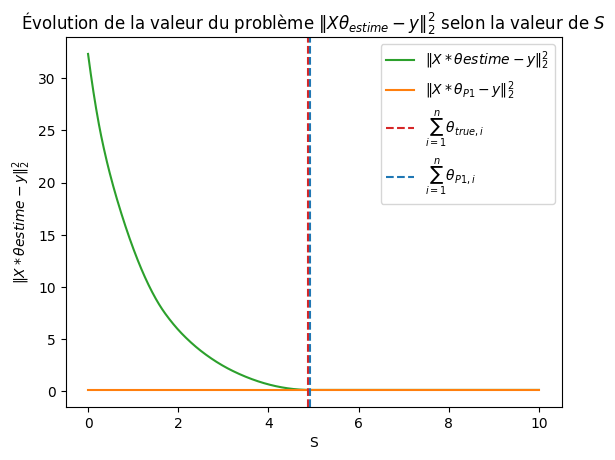

In [18]:
pretty_plot(
    grille_s,
    [problem_vals, [solution_P1[1]] * len(grille_s)],
    legend=[r'$\|X*\theta{estime}-y\|_2^2$', r'$\|X*\theta_{P1}-y\|_2^2$'],
    colors=["tab:green", "tab:orange"],
    vertical_lines=[sum_true, sum_p1],
    legend_vertical=[
        r'$\sum_{i=1}^n \theta_{true,i}$',
        r'$\sum_{i=1}^n \theta_{P1,i}$',
    ],
    colors_vertical=["tab:red", "tab:blue"],
    title=(
        r"Évolution de la valeur du problème "
        r"$\|X\theta_{estime}-y\|_2^2$ selon la valeur de $S$"
    ),
    xlab="S",
    ylab=r'$\|X*\theta{estime}-y\|_2^2$',
)

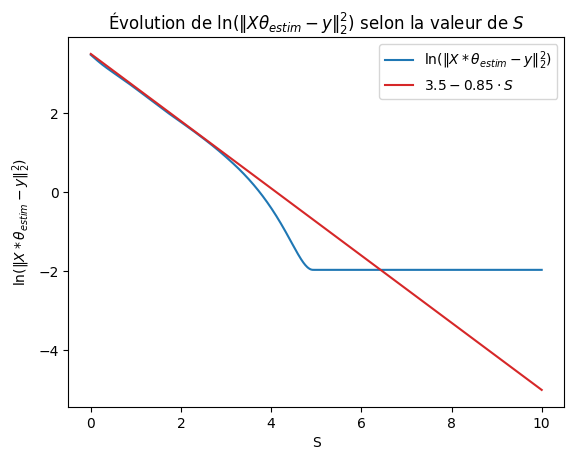

In [19]:
pretty_plot(
    grille_s,
    [np.log(problem_vals), 3.5 - 0.85 * grille_s],
    legend=[
        r"$\ln(\|X*\theta_{estim}-y\|_2^2)$",
        r"$3.5 - 0.85 \cdot S$",
    ],
    colors=["tab:blue", "tab:red"],
    title=(
        r"Évolution de $\ln(\|X\theta_{estim}-y\|_2^2)$ "
        r"selon la valeur de $S$"
    ),
    xlab="S",
    ylab=r"$\ln(\|X*\theta_{estim}-y\|_2^2)$",
)


Lorsque la valeur de $S$ augmente, la valeur de la solution du problème $\|X*\theta-y\|_2^2$ **diminue fortement au départ (de l'ordre de de $S^{-0.85}$)** d'après la seconde visualisation, puis tend prograssivement vers une **valeur plancher correspondant à celle du problème P1** sans cette contrainte.\
\
Sur les petites valeurs de $S$ ($S \leq 2$), **la contrainte $\sum_{i=1}^n \theta_{i}$ est très restrictive** : la solution optimale se trouve au-delà de la frontière des valeurs admissibles et donc les coefficients de $\theta$ sont **fortement sous-estimés**. Dans cet zone,  comme nous l'avions vu pour l'exemple avec $S=1$. Une petite augmentation de $S$ permet de gagner fortement sur la valeur du problème.\
\
Pour $S$ compris entre $2$ et $5$ environ, **la décroissance devient plus lente** et $\|X*\theta-y\|_2^2$ finit par atteindre une **valeur plateau**. Il semble que la courbe de $\|X*\theta{estime}-y\|_2^2$ croise celle de $\|X*\theta_{P1}-y\|_2^2$ pour des valeurs de $S$ proches de $\sum_{i=1}^n \theta_{P1,i}$. Ce comportement est cohérent : c'est à cette borne que **la contrainte cesse d'être active** et que **le problème P2 est équivalent au problème P1** et nous donne donc la même solution, l'omptimum se trouve dans la zone admissible de cette contrainte.

### Évolution de la solution theta

**1. Évolution de la $\|\theta_{estim}\|_{+\infty}$ selon la valeur de S**

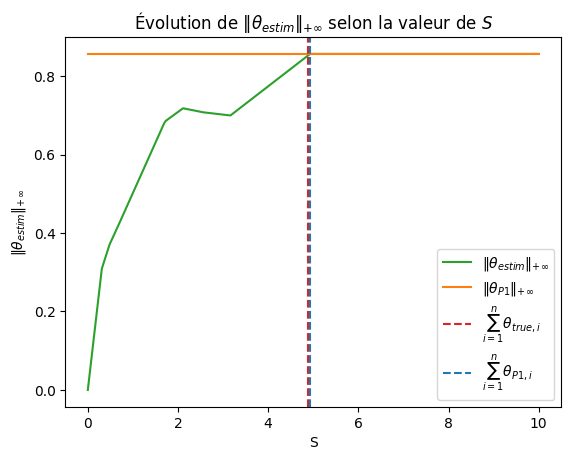

In [20]:
pretty_plot(
    grille_s,
    [norm_inf_vals, [solution_P1[4]] * len(grille_s)],
    legend=[
        r'$\|\theta_{estim}\|_{+\infty}$',
        r'$\|\theta_{P1}\|_{+\infty}$',
    ],
    colors=["tab:green", "tab:orange"],
    vertical_lines=[sum_true, sum_p1],
    legend_vertical=[
        r'$\sum_{i=1}^n \theta_{true,i}$',
        r'$\sum_{i=1}^n \theta_{P1,i}$',
    ],
    colors_vertical=["tab:red", "tab:blue"],
    title=(
        r"Évolution de $\|\theta_{estim}\|_{+\infty}$ "
        r"selon la valeur de $S$"
    ),
    xlab="S",
    ylab=r'$\|\theta_{estim}\|_{+\infty}$',
)

Nous observons que $\|\theta_{estim}\|_{+\infty}$ **augmente globalement avec $S$**, car la contrainte $\sum_{i=1}^n \theta_i \leq S$ limite initiallement les valeurs maximales des coefficients.\
\
Nous pouvons cependant noter une **légère décroissance entre $S=2$ et $S=3$** avant que de nouveau la valeur de $\|\theta_{estim}\|_{+\infty}$ augmente, cela est sûrement du au faut que la contrainte sur les coefficients reste limitante mais que **la meilleure solution tend plutôt à augmenter un peu tous les coefficients plutôt que d'avoir quelques gros coefficients** comme nous avions sur l'exemple avec $S=1$.\
\
Lorsque $S$ se rapproche de $\sum_{i=1}^n \theta_{P1,i}$,  $\: \|\theta_{estim}\|_{+\infty}$ **atteint un plateau** : la contrainte n'est plus active, **le problème P2 se rapporte au problème P1** et donc $\|\theta_{estim}\|_{+\infty} = \|\theta_{P1}\|_{+\infty}$.

**2. Evolution de la norme inf de la différence entre theta_true et theta_estime.**

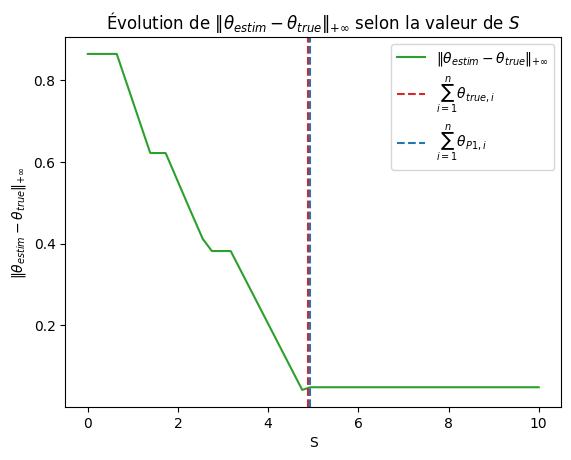

In [21]:
difference_theta_estime_true = norm_inf_difference_thetas(
    theta_estim_vals, theta_true
)

pretty_plot(
    grille_s,
    [difference_theta_estime_true],
    legend=[r'$\|\theta_{estim}-\theta_{true}\|_{+\infty}$'],
    colors=["tab:green"],
    vertical_lines=[sum_true, sum_p1],
    legend_vertical=[
        r'$\sum_{i=1}^n \theta_{true,i}$',
        r'$\sum_{i=1}^n \theta_{P1,i}$',
    ],
    colors_vertical=["tab:red", "tab:blue"],
    title=(
        r"Évolution de $\|\theta_{estim} - \theta_{true}\|_{+\infty}$ "
        r"selon la valeur de $S$"
    ),
    xlab="S",
    ylab=r'$\|\theta_{estim}-\theta_{true}\|_{+\infty}$',
)

La norme infinie de l'erreur $\|\theta_{estim} - \theta_{true}\|_{+\infty}$ **décroit globalement lorsque $S$ augmente**, jusqu'à **atteindre un pleateau** lors que S dépasse $\sum_{i=1}^n \theta_{P1,i}$. Comme expliqué précèdemment, cela correspond au moment où la contrainte cesse d'être active et où **la solution P2 coincide avec la solution P1**.\
\
Cependant, on observe des sortes de **petits plateaux intermédiaires** lorsque $S \leq 4$ : cela est sûrement du au fait que pour ces valeurs, le fait d'**augmenter $S$ a une influence sur les plus petits coefficients et pas sur le plus grand** dont la valeur reste inchangée donc la norme infinie est constante.\
\
Enfin, nous pouvons observer un petit creux juste avant $\sum_{i=1}^n \theta_{true,i}$ : $\|\theta_{estim}-\theta_{true}\|_{+\infty}$ devient plus faible que le plateau final $\|\theta_{P1}-\theta_{true}\|_{+\infty}$.\
\
Regardons plus en détail ce qui se passe pour ces valeurs :

In [22]:
# Grille de valeurs de S à tester limitée entre 4.5 et 5.0
grille_s_bis = np.linspace(4.5, 5.0, 1000)

# Calcul des solutions correspondantes et unpack des résultats
(
    status_vals_bis,
    problem_vals_bis,
    theta_estim_vals_bis,
    residuals_vals_bis,
    norm_inf_vals_bis,
) = grille_solutions_P2(X, y, grille_s_bis, n)

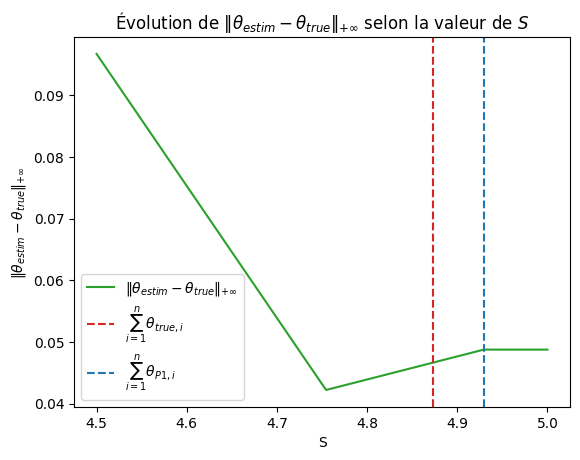

In [23]:
difference_theta_estime_true_bis = norm_inf_difference_thetas(
    theta_estim_vals_bis, theta_true
)

pretty_plot(
    grille_s_bis,
    [difference_theta_estime_true_bis],
    legend=[r'$\|\theta_{estim}-\theta_{true}\|_{+\infty}$'],
    colors=["tab:green"],
    vertical_lines=[sum_true, sum_p1],
    legend_vertical=[
        r'$\sum_{i=1}^n \theta_{true,i}$',
        r'$\sum_{i=1}^n \theta_{P1,i}$',
    ],
    colors_vertical=["tab:red", "tab:blue"],
    title=(
        r"Évolution de $\|\theta_{estim} - \theta_{true}\|_{+\infty}$ "
        r"selon la valeur de $S$"
    ),
    xlab="S",
    ylab=r'$\|\theta_{estim}-\theta_{true}\|_{+\infty}$',
)

Nous voyons bien apparaitre un creux juste avant $\sum_{i=1}^n \theta_{true,i}$ : juste avant que la contrainte ne devienne inactive ($S = \sum_{i=1}^n \theta_{P1,i}$), la répartition des valeurs des coefficients produit temporairement un meilleur résultat pour $\|\theta_{estim}-\theta_{true}\|_{+\infty}$. Or, en ce point, la valeur du problème est très proche de celle du plateau, donc il pourrait peut-être intéressant de "tomber" dans ce creux.

Pour cela, nous pouvons exploiter les propriétés de simulation de $\theta$, en effet $\theta \sim Unif([0;1],n)$ donc $\mathbb{E}[\sum_{i=1}^n \theta_{i}] = n\times \mathbb{E}[\theta_i] = 0.5n$. Ainsi, prendre $S \approx 0.5n$ peut être intéressant pour essayer justement de tomber dans ce creux.\
\
Pour essayer de valider cette idée, nous allons regarder, pour différentes valeurs de S, la valeur moyenne sur $N=200$ essais de $\|\theta_{estim}-\theta_{true}\|_{+\infty}$ en modifiant à chaque fois les valeurs de $X$,$xi$ et $\theta_{true}$ en comparant l'erreur faite avec la contrainte (P2) et sans la contrainte (P1).

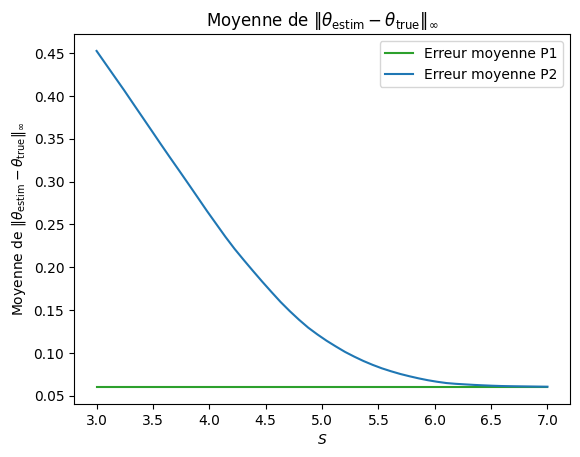

In [24]:
# Expérience comparant P1 et P2 sur plusieurs tirages et valeurs de S
N = 200
s_values = np.linspace(3, 7, 50)

max_errors_mean_p1 = []
max_errors_mean_p2 = []

# Générer N tirages fixes
x_list = [np.random.randn(m, n) for _ in range(N)]
theta_true_list = [np.random.rand(n) for _ in range(N)]
xi_list = [np.random.randn(m) for _ in range(N)]
y_list = [
    np.dot(x_list[i], theta_true_list[i]) + sigma * xi_list[i]
    for i in range(N)
]

# Boucle sur les valeurs de S
for s in s_values:
    errors_p1 = []
    errors_p2 = []

    for X_test, y_test, theta_true_test in zip(
        x_list, y_list, theta_true_list
    ):
        # Problème P1
        solution_p1 = probleme_P1(X_test, y_test, n)
        theta_est_p1 = solution_p1[2]
        error_inf_p1 = np.linalg.norm(theta_est_p1 - theta_true_test, np.inf)
        errors_p1.append(error_inf_p1)

        # Problème P2
        solution_p2 = probleme_P2(X_test, y_test, s, n)
        theta_est_p2 = solution_p2[2]
        error_inf_p2 = np.linalg.norm(theta_est_p2 - theta_true_test, np.inf)
        errors_p2.append(error_inf_p2)

    # Moyenne des erreurs sur N tirages
    max_errors_mean_p1.append(np.mean(errors_p1))
    max_errors_mean_p2.append(np.mean(errors_p2))

# Affichage
pretty_plot(
    s_values,
    [max_errors_mean_p1, max_errors_mean_p2],
    legend=["Erreur moyenne P1", "Erreur moyenne P2"],
    colors=["tab:green", "tab:blue"],
    title=r"Moyenne de $\|\theta_{\rm estim}-\theta_{\rm true}\|_\infty$",
    xlab=r"$S$",
    ylab=r"Moyenne de $\|\theta_{\rm estim}-\theta_{\rm true}\|_\infty$",
)

Je n'arrive pas vraiment à observer ce résultat, je m'attendais à voir qu'à partir d'environ S=5 (0.5*n=0.5=10 dans notre cas), les deux courbes se croiseraient et qu'on aurait un petit creux. Cela est peut-être du au fait que la différence enter les normes infinies dans le cas P1 et avec le S optimal ne sont pas assez grande et ne permet pas de compenser le fait que dans certains cas où $\sum_{i=1}^n \theta_{true,i}$ est plus grand que 5 alors $\|\theta_{\rm S=5}-\theta_{\rm true}\|_\infty$ devient plus grand que l'écart entre le bas du creux et le plateau.

Une autre possibilité pourrait peut-être d'estimer un $\theta_{P1}$ dans une premier temps sans mettre de contrainte sur $\sum_{i=1}^n \theta_{i}$, puis de refaire une estimation en mettant cette fois une contrainte $\sum_{i=1}^n \theta_{estime,i} \leq \sum_{i=1}^n \theta_{P1,i}$ pour essayer justement de tomber dans ce creux.

# 4- Observation des variables duales

> **Question:** Écrivez une fonction qui résoud le problème (P2) à partir de `X`, `y`, et `S` et qui retourne la solution ainsi que les variables duales du problème

In [25]:
def probleme_P2_dual(X, y, S, n, verbose=False):
    """
    Résout le problème d'optimisation (P2) avec retour sur les valeurs duales.

    Args:
        X (numpy.ndarray): Matrice de taille m*n.
        y (numpy.ndarray): Vecteur de taille m.
        S (int or float): Valeur contraignant la somme des coefficients de theta.
        n (int): Taille du vecteur theta.
        verbose (bool, optional): Affiche les détails de la résolution si True. Par défaut False.

    Returns:
        list: Contient :
            - status (str): Statut de l'optimisation.
            - valeur_probleme (float): Valeur minimisée du problème.
            - theta_estime (numpy.ndarray): Solution optimisée pour theta.
            - residuals (numpy.ndarray): Résidus y - X*theta.
            - norme_inf (float): Norme infinie de la solution estimée.
            - dual_positivite (numpy.ndarray): Valeurs duales pour la contrainte de positivité.
            - dual_stabilite (float): Valeur duale pour la contrainte de stabilité.
    """
    # Définition du problème d'optimisation
    theta = cp.Variable(n)
    L = cp.norm(X @ theta - y, 2)**2
    objective = cp.Minimize(L)
    contrainte_positivite = theta >= 0
    contrainte_stabilite = sum(theta) <= S
    prob = cp.Problem(objective, [contrainte_positivite, contrainte_stabilite])

    # Résolution du problème
    prob.solve(verbose=verbose)

    # Extraction des résultats
    status = prob.status
    valeur_probleme = L.value
    theta_estime = theta.value
    residuals = y - X @ theta_estime
    norme_inf = np.linalg.norm(theta_estime, np.inf)
    dual_positivite = prob.constraints[0].dual_value
    dual_stabilite = prob.constraints[1].dual_value

    return [status, valeur_probleme, theta_estime, residuals, norme_inf, dual_positivite, dual_stabilite]


In [26]:
solution_P2_dual = probleme_P2_dual(X,y,1,n)

In [27]:
print(f'Les valeurs duales pour la contrainte de positivitié des coefficient de theta sont :\n{solution_P2_dual[5]}')

Les valeurs duales pour la contrainte de positivitié des coefficient de theta sont :
[5.06537756e-08 9.28311333e+00 1.64790550e-08 2.11677184e+00
 8.45092333e+00 1.15998614e+01 3.66848215e-08 3.37487792e-08
 6.10139956e+00 5.29427210e+00]


In [28]:
print(f'La valeur duale de la contrainte de stabilité est de :\n{solution_P2_dual[6]}')

La valeur duale de la contrainte de stabilité est de :
11.658984899027535


Dans le cadre de l'optimisation sous contrainte, les valeurs duales permettent de savoir quelles contraintes sont difficile à respecter (pour lesquelles il y a le plus de "résistance").\
\
Pour $S=1$ :
- Nous observons que les valeurs duals des coordonnées 2,4,5,6,9 et 10 sont élevées ($\geq 2$), cela signifie que **la contrainte de positivité est difficile à respecter sur ces coordonnées**.
- Nous pouvons constater également que la valeur duale pour la contrainte de stabilité est élevée, **la contrainte est difficile à respecter** et relaxer cette contrainte permettrait d'obtenir un meilleure résultat vis-à-vis de la solution du problème.

> **Question:** Pour différentes valeurs de $S$, observez quelles sont les contraintes actives et non-actives. Mettez en relation vos observations avec la valeur de la solution.

On note $\lambda_1$ le vecteur contenant les valeurs duales pour la contrainte de positivité des coefficent de $\theta$ et $\lambda_2$ la valeur duale pour la contrainte de stabilité.

In [29]:
# On n'inclut pas 0 parce que la valeur duale lambda_2 liée à la
# contrainte sur la somme des coefficients explose.
grille_s = np.linspace(0.001, 10, 1000)
grille_duals = grille_solutions_P2_dual(X, y, grille_s, n)

In [30]:
# Extraire les listes pertinentes depuis `grille_duals`
valeur_probleme_vals = grille_duals[0]
dual_norminf_positivite_vals = grille_duals[2]
dual_stabilite_vals = grille_duals[3]

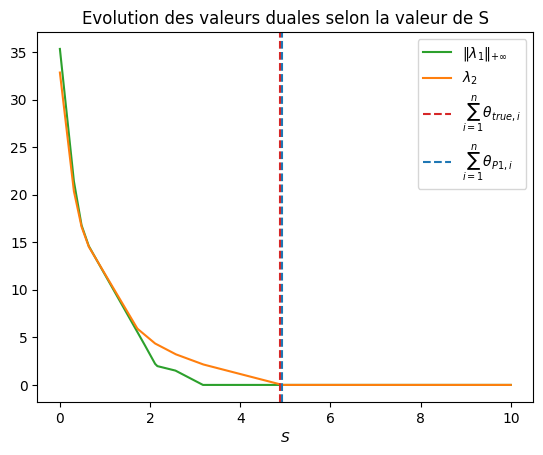

In [31]:
pretty_plot(
    grille_s,
    [dual_norminf_positivite_vals, dual_stabilite_vals],
    legend=[r'$\|\lambda_1\|_{+\infty}$', r'$\lambda_2$'],
    colors=["tab:green", "tab:orange"],
    vertical_lines=[sum_true, sum_p1],
    legend_vertical=[
        r'$\sum_{i=1}^n \theta_{true,i}$',
        r'$\sum_{i=1}^n \theta_{P1,i}$',
    ],
    colors_vertical=["tab:red", "tab:blue"],
    title=r"Evolution des valeurs duales selon la valeur de S",
    xlab=r"$S$",
    ylab="",
)

Nous pouvons observer que les deux valeurs $\|\lambda_1\|_{+\infty}$ et $\lambda_2$ diminuent lorsque $S$ augmente avant d'atteindre 0 lorsque $S \geq \sum_{i=1}^n \theta_{P1,i}$. C'est cohérent :
- Lorsque $S$ est petit, la contrainte de stabilité $\sum_{i=1}^n \theta_i \leq S$ est **très difficile à respecter** puisque **l'optimum est loin de la frontière des valeurs adimissibles** donc la valeur duale associée $\lambda_2$ est grande. La courbe atteint un plateau en 0 lorsque que $S = \sum_{i=1}^n \theta_{P1,i}$ et que le problème P2 est équivalent au problème P1.
- Même si la contrainte de positivité n'est pas liée directement à $S$, lorsque celui-ci est très petit, la **zone admissible est très petite** et donc il serait possible d'obtenir de plus petites valeurs de solution du problème en prennant des coefficients négatifs ce qui a pour effet de **rendre la valeur duale pour certains coefficients grande** ce qui affecte donc $\|\lambda_1\|_{+\infty}$. On voit bien que ça n'est pas directement lié à $S$ puisque qu'à partir de $S \approx 3$, $\|\lambda_1\|_{+\infty}$ devient très très petite, la contrainte n'est pas difficile à respecter pour l'ensemble des coefficients.

## Utilisation de l'IA (conformément à la chartre d'utilisation de l'IA)
J'ai utilisé ChatGPT-5 pour appliquer la PEP8 sur mon code, faire certaines des descriptions de mes fonctions, corriger quelques erreurs mineures de syntaxe ou de logique dans mes fonctions et pour m'aider à fluidifier mes explicaitons et observations dans ce rapport.